# Notebook Purpose
- follow-up on QuiescentSources.ipynb and TypeDifferentiation.ipynb to better understand and separate types 5, 6, and 7; and connect these sources to transitioning sources

### Goals
- investigate ~quiescent parts of transitioning sources
- satisfactory separation of types 6 and 7
- (ideas of) how to separate 6 from other sources as well
- can re-type any 5s and 6s based on direct (LC) comparison
    - is difference extent/type of variability or timescale of variability?
- overall: want to understand boundaries between 5, 6, 7
- can add calibrated column to allsummtab.csv?

- can argue that some type 6s just haven't been given enough time (by OGLE) to be seen outside of quiescence?
    - based on timescale of transitioning sources and spin period or orbital period
### Summary

### To-Dos

In [53]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('summtab.csv')
alls = pd.read_csv('allsummtab.csv')

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

In [2]:
mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']
def plot(s):
    try: iband, vband = o.getIV(s,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(s,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

#### number and description of transitioning sources to include
- 55: transition from ~quiescence (type 6) to type 1
- 32, 30, 39, 50, 119
- parts of 10, 11, 14, 19, maybe 34, maybe 73

#### broader framing idea
- divide by faint/bright/no base using (base number and) skew
- faint base: 1 and 4 (but would probably want to re-number using this logic
    - what differentiates
        - timescale? periodicity?
        - width of flares
    - do any sources transition between 1 and 4?
    - compare/contrast color-magnitude diagrams
- bright base: 2 and 3
    - what differentiates
        - neighboring/correlated big dips
- no base: 5, 6, 7
    
    

In [3]:
tsrc = []
for a in range(len(alls)):
    row = alls.loc[a]
    sn = int(row['src_n'])
    if '+' in str(row['type']): tsrc.append(sn)

In [4]:
#transition source numbers -- ones with 6/7 part are listed in markdown above
tsrc

[2, 10, 11, 14, 19, 27, 30, 32, 34, 39, 50, 52, 73, 97, 119]

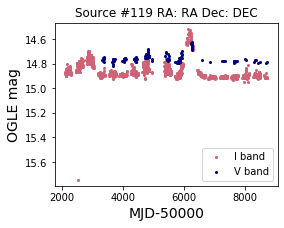

In [5]:
plot(119) #was checking which ones have quiescent parts

In [6]:
def gettype(num='6',tab=alls):
    typen = []
    for a in range(len(alls)):
        if tab.loc[a]['type']==num:
            typen.append(tab.loc[a]['src_n'])
    return typen

In [7]:
type6 = gettype()
type7 = gettype(num='7')

Text(0.5, 0, 'det I stdev/overall I stdev')

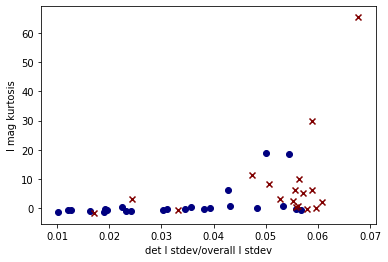

In [8]:
#IQR similar
for t in type6:
    row = alls[alls['src_n']==t]
    plt.scatter(row['det stdev I']/row['stdev I'],row['I kurtosis'],color='navy')
#     plt.text(row['det stdev I']/row['I range'],row['I kurtosis'],str(int(row['src_n'])))
for t in type7:
    row = alls[alls['src_n']==t]
    plt.scatter(row['det stdev I']/row['stdev I'],row['I kurtosis'],color='maroon',marker='x')
#     plt.text(row['det stdev I']/row['stdev I'],row['I kurtosis'],str(int(row['src_n'])))
plt.ylabel('I mag kurtosis')
plt.xlabel('det I stdev/overall I stdev')

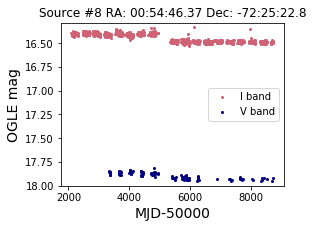

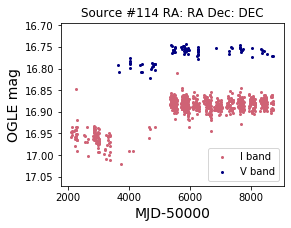

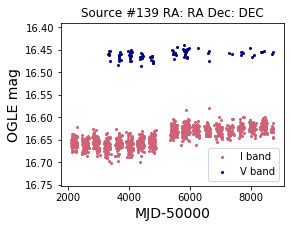

In [9]:
#maybe offset in x due to calibration so not too worried
plot(8)
plot(114)
plot(139)

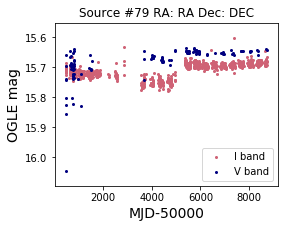

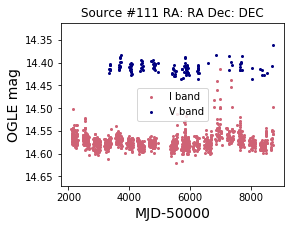

In [10]:
#potential false positives (type 6 that are in type 7 region)
plot(79) #quite possibly a type 7; need to zoom and check calibration
plot(111) #looks like type6

# Investigate Transition Sources


### get indices of approximate quiescence for each
- in dictionary idict

In [11]:
#sources to investigate in this section
nums = [55,32,30,39,50,119,10,11,14,19,34,73]

In [12]:
idict = dict.fromkeys(nums,())

In [13]:
idict

{55: (),
 32: (),
 30: (),
 39: (),
 50: (),
 119: (),
 10: (),
 11: (),
 14: (),
 19: (),
 34: (),
 73: ()}

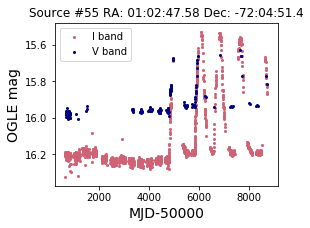

In [14]:
#first determine upper and lower inds of quiescent region for each source
n = 55
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [15]:
# plt.scatter(iband['MJD-50000'][:1000],iband['I mag'][:1000],color=pink)
idict[55] = (0,1000)

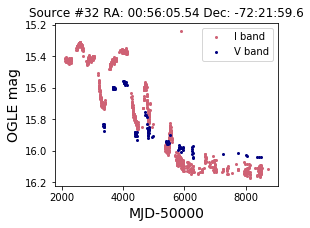

In [16]:
n = nums[1]
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [17]:
# plt.scatter(iband['MJD-50000'][940:],iband['I mag'][940:],color=pink)
idict[n] = (940,1202)

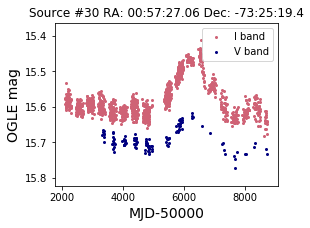

In [18]:
n = nums[2]
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [19]:
# plt.scatter(iband['MJD-50000'][:730],iband['I mag'][:730],color=pink)
idict[n] = (0,730)

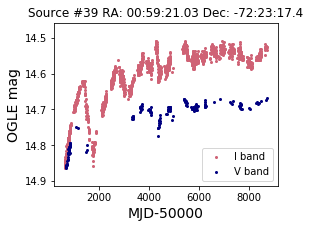

In [20]:
n = nums[3]
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [21]:
#keeping edges to show retainment of periodicity
# plt.scatter(iband['MJD-50000'][1050:],iband['I mag'][1050:],color=pink)
idict[n] = (1050,1801)

<Quantity 1059.18529296>

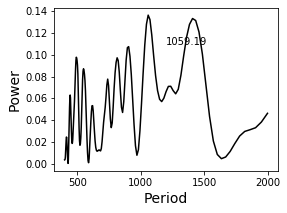

In [22]:
o.periodogram(iband,minp=400,maxp=2000)

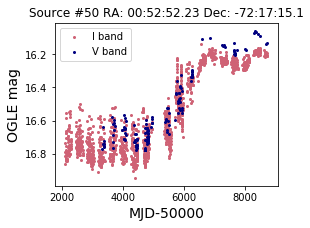

In [23]:
n = nums[4]
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [24]:
# plt.scatter(iband['MJD-50000'][:800],iband['I mag'][:800],color=pink)
idict[n] = (0,800)

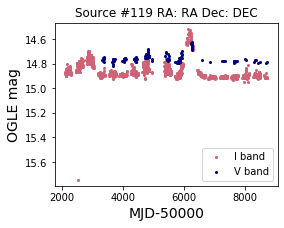

In [25]:
n = nums[5] #just use end part here
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [26]:
# plt.scatter(iband['MJD-50000'][1110:],iband['I mag'][1110:],color=pink,s=6)
idict[n] = (1110,1496)
# plt.ylim(15,14.8)

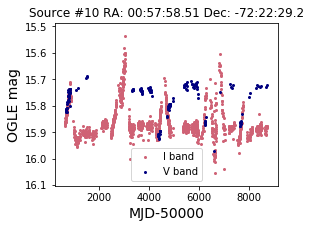

In [27]:
n = nums[6] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [28]:
#just take one good quiescent chunk
# plt.scatter(iband['MJD-50000'][610:830],iband['I mag'][610:830],color=pink,s=6)
idict[n] = (610,830)

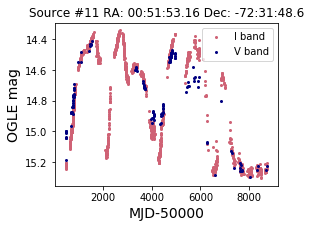

In [29]:
n = nums[7] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [30]:
# plt.scatter(iband['MJD-50000'][1340:],iband['I mag'][1340:],color=pink,s=6)
idict[n] = (1340,1495)

(5377, 9167.459000626763)

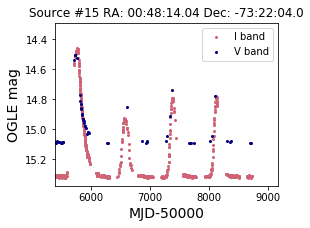

In [31]:
#sidenote: equivalent timescale to 14 for type 1 surce
plot(15)
plt.xlim(5377,)

In [32]:
np.min(iband['MJD-50000'])

466.60147

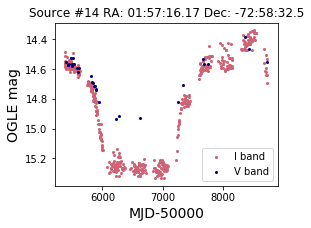

In [33]:
n = nums[8] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [34]:
# plt.scatter(iband['MJD-50000'][190:330],iband['I mag'][190:330],color=pink,s=6)
idict[n] = (190,330)

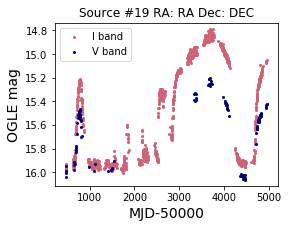

In [35]:
n = nums[9] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [36]:
# plt.scatter(iband['MJD-50000'][165:300],iband['I mag'][165:300],color=pink,s=6)
idict[n] = (165,300)

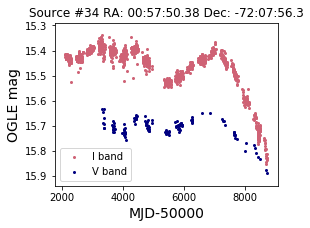

In [37]:
n = nums[10] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [38]:
#fine to use as limit between 5 and 6
# plt.scatter(iband['MJD-50000'][:600],iband['I mag'][:600],color=pink,s=6)
idict[n] = (0,600)

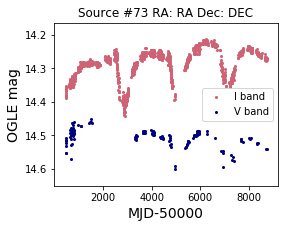

In [39]:
n = nums[11] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [40]:
# plt.scatter(iband['MJD-50000'][170:500],iband['I mag'][170:500],color=pink,s=6)
idict[n] = (170,500) #quite approximate; repeated throughout lightcurve

In [41]:
idict #now have indices of ~quiescence for weird/transitioning sources
#other sources sometimes have ~quiescence for this long

{55: (0, 1000),
 32: (940, 1202),
 30: (0, 730),
 39: (1050, 1801),
 50: (0, 800),
 119: (1110, 1496),
 10: (610, 830),
 11: (1340, 1495),
 14: (190, 330),
 19: (165, 300),
 34: (0, 600),
 73: (170, 500)}

### periodicity search within quiescence
- be careful since not a lot of points for some
- show periodograms and phase-folded data

In [42]:
len(nums)

12

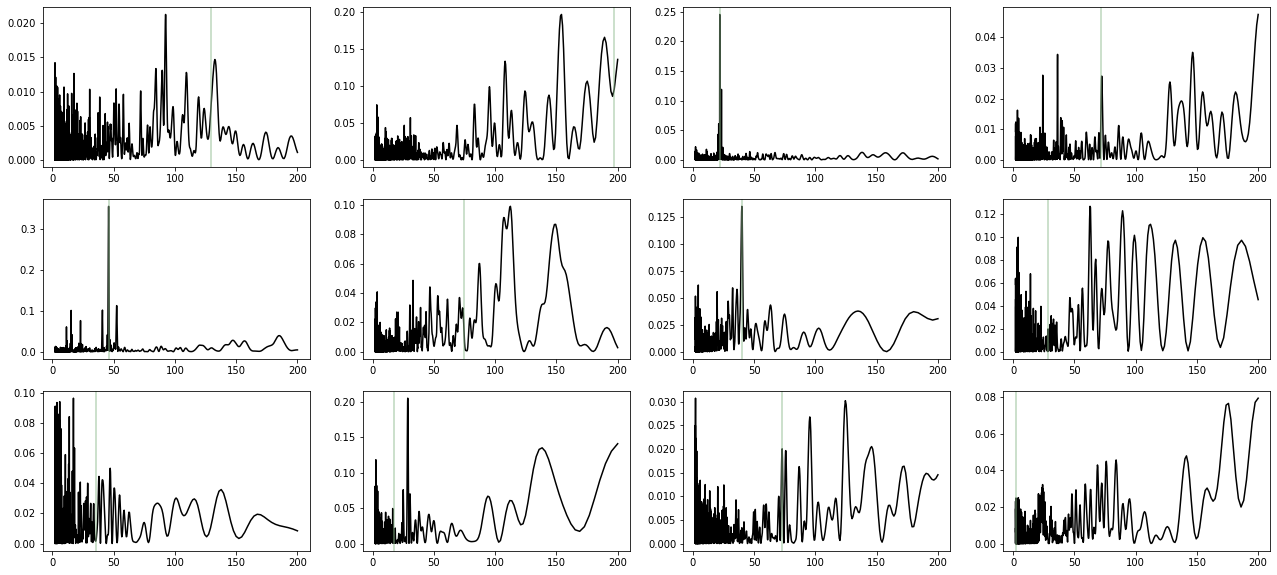

In [43]:
#loop through sources and look at power in LS periodogram
#remake into subplots to not have such long output
fig = plt.figure(figsize=(22,10))
i = 1
for n in nums:
    #get LC
    try: iband, vband = o.getIV(n,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(n,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    #run periodogram using inds from idict
    start,end = idict[n][0],idict[n][1]
    ax = fig.add_subplot(3,4,i)
    freq,power,bp = o.periodogram(iband[start:end],minp=2,maxp=200,more=True,plot=False)
    ax.plot(1/freq,power,color='black')
    row = alls[alls['src_n']==n]
    if float(row['est. period'])!=0: 
        pd = float(row['est. period'])
#         print(pd)
        ax.axvline(pd,color='darkseagreen',alpha=0.6)
    else: 
        pd = float(row['best auto det pd'])
#         print(pd)
        ax.axvline(pd,color='darkseagreen',alpha=0.6)  
    i+=1

summary: general retainment of (some) periodicity, often the best/established period
- low sampling sometimes, so wouldn't draw conclusion that period changed
- follow-up below: **phase-folding each**

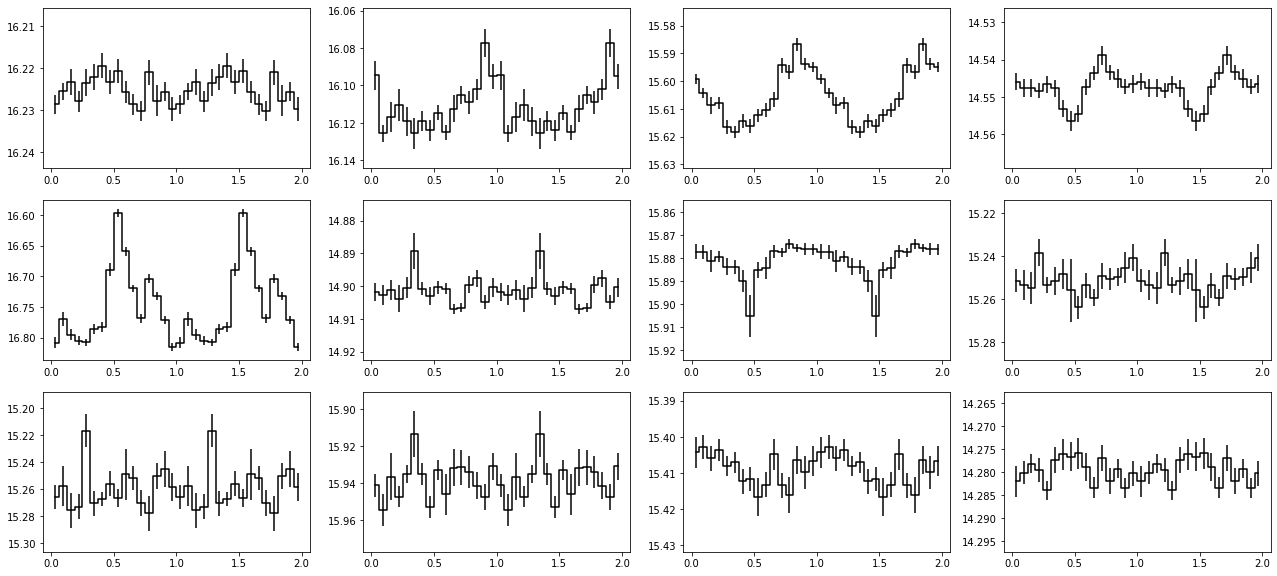

In [45]:
fig = plt.figure(figsize=(22,10))
i = 1
for n in nums:
    #get LC
    try: iband, vband = o.getIV(n,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(n,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    start,end = idict[n][0],idict[n][1]
    ax = fig.add_subplot(3,4,i)
    #get best overall detrended period from table
    row = alls[alls['src_n']==n]
    pd = float(row['best auto det pd'])
    #plot phase-fold with subset of points
    mid,avg,err = o.meanphase(iband[start:end],pd,pbins=16,det=False,med=False,double=True,stdev=True,divide=True,sterr=True)
    ax.step(mid,avg,where='mid',color='black')
    ax.errorbar(mid,avg,yerr=err,color='black',linestyle='none')
    maxi,mini = np.max(avg)+np.max(err),np.min(avg)-np.max(err)
    ax.set_ylim(maxi+.01,mini-.01)
    i+=1

above: no detrending, but shouldn't be important
- take-away: not seeing a disappearance in period
- a couple don't look fantastic but generally good --> already seems more type 6 than 7

### plot on kurtosis vs. ___ plot


In [74]:
tkurt = []
tskew = []
tstd = []
tdetstd = []
#get kurtosis, skew, stdev
for n in nums: 
    #get LC
    try: iband, vband = o.getIV(n,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(n,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    #indices from dict
    start,end = idict[n][0],idict[n][1]
    tkurt.append(st.kurtosis(iband['I mag'][start:end]))
    tskew.append(st.skew(iband['I mag'][start:end]))
    stdev = np.std(iband['I mag'][start:end])
    tstd.append(stdev)
    #detrend to get detrended std
    ctab = iband[start:end]
    o.splinedetrend(ctab,window=20)
    tdetstd.append(np.std(ctab['I detrend'])/stdev)

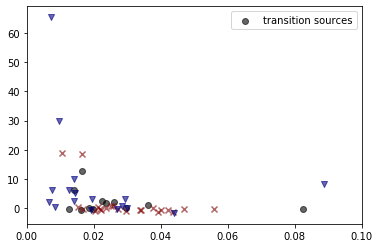

In [81]:
t6kurt = []
t7kurt = []
plt.scatter(tstd,tkurt,color='black',label='transition sources',alpha=0.6)
for t in type6:
    row = alls[alls['src_n']==t]
    plt.scatter(row['stdev I'],row['I kurtosis'],color='maroon',marker='x',alpha=0.6)
    t6kurt.append(float(row['I kurtosis']))
for t in type7:
    row = alls[alls['src_n']==t]
    plt.scatter(row['stdev I'],row['I kurtosis'],color='navy',marker='v',alpha=0.6)
    t7kurt.append(float(row['I kurtosis']))
plt.xlim(0,.1)
plt.legend()
# plt.ylim(-2,10)

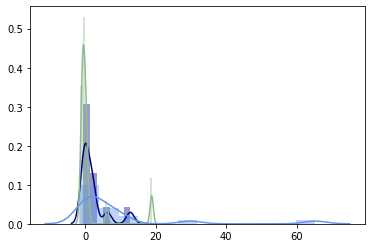

In [84]:
sb.distplot(tkurt,color='navy')
sb.distplot(t6kurt,color='darkseagreen')
sb.distplot(t7kurt,color='cornflowerblue')
#transition looking like combo of 6 and 7, also as shown in scatter plot

### by-eye characterization using plot subsets

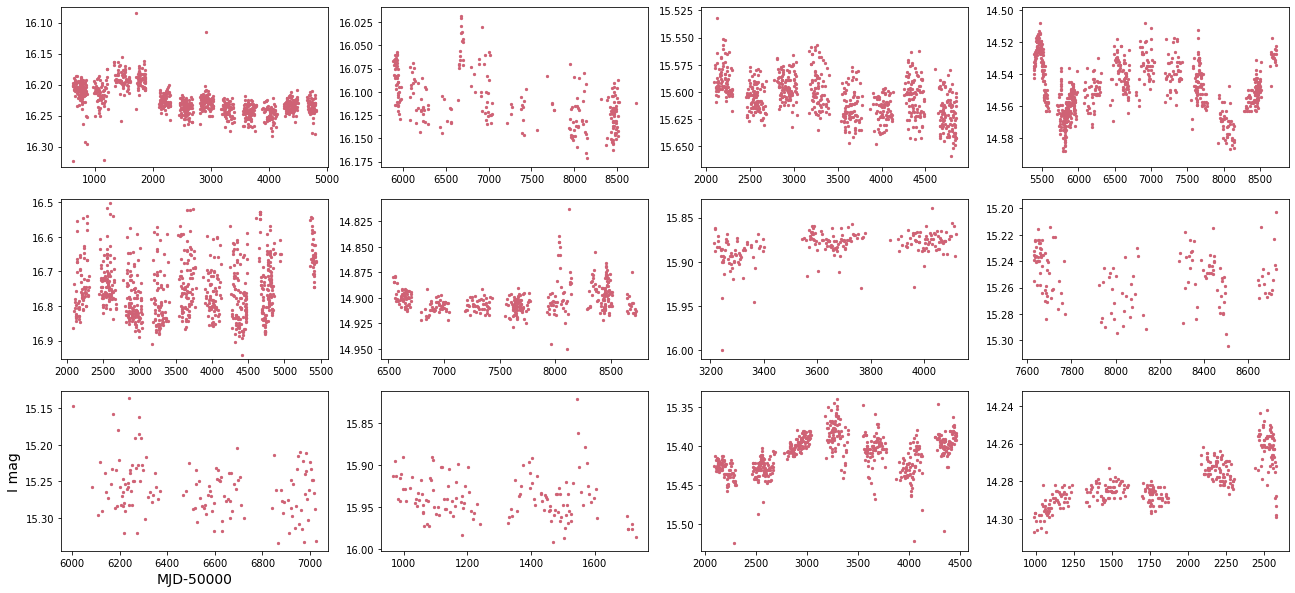

In [86]:
fig = plt.figure(figsize=(22,10))
i = 1
for n in nums:
    #get LC
    try: iband, vband = o.getIV(n,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(n,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    start,end = idict[n][0],idict[n][1]
    ax = fig.add_subplot(3,4,i)
    tab = iband[start:end]
    ax.scatter(tab['MJD-50000'],tab['I mag'],color=pink,s=5)
    maxi,mini = np.max(tab['I mag']),np.min(tab['I mag'])
    ax.set_ylim(maxi+.01,mini-.01)
    if i == 9:
        ax.set_ylabel('I mag',fontsize=14)
        ax.set_xlabel('MJD-50000',fontsize=14)    
    i+=1